# DD Case Study Datasets

# Import lib & files

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Analytics_Sample_Data_rsc.csv')

In [30]:
df.columns

Index(['Customer_placed_order_datetime',
       'Placed_order_with_restaurant_datetime',
       'Driver_at_restaurant_datetime', 'Delivered_to_consumer_datetime',
       'Driver_ID', 'Restaurant_ID', 'Consumer_ID', 'Is_New',
       'Delivery_Region', 'Is_ASAP', 'Order_total', 'Amount_of_discount',
       'Amount_of_tip', 'Refunded_amount'],
      dtype='object')

# Data Cleaning

## missing value check

In [31]:
for col in df.columns: 
    print(col, df[col].isna().sum(), "missing")

Customer_placed_order_datetime 0 missing
Placed_order_with_restaurant_datetime 40 missing
Driver_at_restaurant_datetime 4531 missing
Delivered_to_consumer_datetime 0 missing
Driver_ID 0 missing
Restaurant_ID 0 missing
Consumer_ID 0 missing
Is_New 0 missing
Delivery_Region 26 missing
Is_ASAP 0 missing
Order_total 0 missing
Amount_of_discount 0 missing
Amount_of_tip 0 missing
Refunded_amount 0 missing


## remove duplicate rows

In [32]:
print("original records #：", len(df))
df = df.drop_duplicates()
print("after deleting records：", len(df))

original records #： 18078
after deleting records： 18078


## time format conversion

In [33]:
def hms_to_sec(val):
    """transfer HH:MM:SS into seconds"""
    if pd.isna(val):
        return np.nan
    time_str = str(val).split()[-1]  
    h, m, s = map(int, time_str.split(":"))
    return h*3600 + m*60 + s

def time_diff(t1, t2):
    """compute time difference in seconds, consider the case across midnight"""
    if pd.isna(t1) or pd.isna(t2):
        return np.nan
    return t2 - t1 if t2 >= t1 else t2 + 86400 - t1


df['order_to_rest'] = df.apply(
    lambda r: time_diff(hms_to_sec(r['Customer_placed_order_datetime']),
                        hms_to_sec(r['Placed_order_with_restaurant_datetime'])),
    axis=1
)

df['rest_to_csmer'] = df.apply(
    lambda r: time_diff(hms_to_sec(r['Driver_at_restaurant_datetime']),
                        hms_to_sec(r['Delivered_to_consumer_datetime'])),
    axis=1
)

df['total_delivery_time'] = df.apply(
    lambda r: time_diff(hms_to_sec(r['Customer_placed_order_datetime']),
                        hms_to_sec(r['Delivered_to_consumer_datetime'])),
    axis=1
)

df['dasher_waiting_time'] = df.apply(
    lambda r: time_diff(hms_to_sec(r['Placed_order_with_restaurant_datetime']),
                        hms_to_sec(r['Driver_at_restaurant_datetime'])),
    axis=1
)

df['dasher_delivery_time'] = df.apply(
    lambda r: time_diff(hms_to_sec(r['Driver_at_restaurant_datetime']),
                        hms_to_sec(r['Delivered_to_consumer_datetime'])),
    axis=1
)   

# Time logic check
viol1 = (df['total_delivery_time'] < df['rest_to_csmer'])  # 
viol2 = (df['total_delivery_time'] < df['order_to_rest'])  #
viol3 = (df['total_delivery_time'] < df['dasher_waiting_time'])  
viol4 = (df['total_delivery_time'] < df['dasher_delivery_time'])
# delete the violations
print('before delete: ',len(df))
df = df[~(viol1 | viol2 | viol3 | viol4)]  
df = df[
    (df['total_delivery_time'] <= 8*3600) & # total delivery time not possible exceed 8h
    (df['order_to_rest'] <= 2*3600)  # order to restaurant time not possible exceed 2h
]
print('after delete: len(df)', len(df))
print(df[['order_to_rest','rest_to_csmer','total_delivery_time']].describe())

before delete:  18078
after delete: len(df) 17335
       order_to_rest  rest_to_csmer  total_delivery_time
count   17335.000000   12990.000000         17335.000000
mean      725.477819    1445.020939          3241.897375
std      1115.404946     630.176513          1566.323436
min         6.000000      39.000000           593.000000
25%        89.000000    1015.000000          2216.000000
50%       249.000000    1336.000000          2846.000000
75%       929.000000    1753.750000          3787.000000
max      7188.000000   10091.000000         21747.000000


# Add new columns


In [34]:
df['original_order_total'] = df['Order_total'] + df['Amount_of_discount']
df["Has_Discount"] = (df["Amount_of_discount"] > 0).astype(int)
df['Refund?'] = (df['Refunded_amount'] > 0).astype(int)
df["order_day"] = df["Customer_placed_order_datetime"].str.split().str[0].astype(int)

# Customer indicators 

In [35]:
# adoption Rate
adoption_rate = (df['Amount_of_discount'] > 0).sum() / len(df) * 100
print(f"❤️Adoption Rate: {adoption_rate:.2f}%")
# Customer-paid Order Value (AOV) 
aov_w_discount = df[df['Amount_of_discount'] > 0]['Order_total'].mean()
aov_w0_discount = df[df['Amount_of_discount'] == 0]['Order_total'].mean()
print(f"❤️Customer-paid：AOV with discount: {aov_w_discount:.2f}, AOV without discount: {aov_w0_discount:.2f}")
# Gross AOV
gaov_w_discount = df[df['Amount_of_discount'] > 0]['original_order_total'].mean()
gaov_w0_discount = df[df['Amount_of_discount'] == 0]['original_order_total'].mean()
print(f"❤️Gross AOV with discount: {gaov_w_discount:.2f}, Gross AOV without discount: {gaov_w0_discount:.2f}")
# Incremental lift
incremental_lift = (gaov_w_discount - gaov_w0_discount) / gaov_w0_discount * 100
print(f"❤️Incremental lift: {incremental_lift:.2f}%")
# refund rate
refund_rate_w_discount = (df[df['Amount_of_discount'] > 0]['Refunded_amount'] > 0).sum() / len(df[df['Amount_of_discount'] > 0]) * 100
refund_rate_w0_discount = (df[df['Amount_of_discount'] == 0]['Refunded_amount'] > 0).sum() / len(df[df['Amount_of_discount'] ==0]) * 100
print(f"❤️Refund rate with discount: {refund_rate_w_discount:.2f}%, Refund rate without discount: {refund_rate_w0_discount:.2f}%")
# new customer rate
return_customer_rate_w_discount = (df[df['Amount_of_discount'] > 0]['Is_New'] == 0).sum() / len(df) * 100
return_customer_rate_w0_discount = (df[df['Amount_of_discount'] == 0]['Is_New'] == 0).sum() / len(df) * 100
print(f"❤️return customer rate with discount: {return_customer_rate_w_discount:.2f}%, return customer rate without discount: {return_customer_rate_w0_discount:.2f}%")
# total delivery time
total_delivery_time_w_discount = df[df['Amount_of_discount'] > 0]['total_delivery_time'].mean() 
total_delivery_time_w0_discount = df[df['Amount_of_discount'] == 0]['total_delivery_time'].mean()
print(f"❤️Total delivery time with discount: {total_delivery_time_w_discount:.2f} seconds, Total delivery time without discount: {total_delivery_time_w0_discount:.2f}) seconds")

❤️Adoption Rate: 15.28%
❤️Customer-paid：AOV with discount: 45.75, AOV without discount: 49.53
❤️Gross AOV with discount: 54.59, Gross AOV without discount: 49.53
❤️Incremental lift: 10.20%
❤️Refund rate with discount: 2.53%, Refund rate without discount: 2.66%
❤️return customer rate with discount: 11.56%, return customer rate without discount: 69.07%
❤️Total delivery time with discount: 3158.94 seconds, Total delivery time without discount: 3256.85) seconds


# Dasher indicators

In [36]:

# Tip rate  = mean(Amount_of_tip / Order_total) 
tip_rate_w_discount = df[df['Amount_of_discount'] > 0]['Amount_of_tip'].sum() / df[df['Amount_of_discount'] > 0]['original_order_total'].sum() *100
tip_rate_w_discount_discounted_order_total = df[df['Amount_of_discount'] > 0]['Amount_of_tip'].sum() / df[df['Amount_of_discount'] > 0]['Order_total'].sum() *100
tip_rate_w0_discount = df[df['Amount_of_discount'] == 0]['Amount_of_tip'].sum() / df[df['Amount_of_discount'] == 0]['original_order_total'].sum() *100
print(f"❤️Tip rate with discount: {tip_rate_w_discount:.5f}, Tip rate with dict (dicounted order):{tip_rate_w_discount_discounted_order_total:.5f},Tip rate without discount: {tip_rate_w0_discount:.5f}")
# mean tip amount
mean_tip_w_discount = df[df['Amount_of_discount'] > 0]['Amount_of_tip'].mean()
mean_tip_w0_discount = df[df['Amount_of_discount'] == 0]['Amount_of_tip'].mean()
print(f"❤️Mean tip amount with discount: {mean_tip_w_discount:.2f}, Mean tip amount without discount: {mean_tip_w0_discount:.2f}")
# average dasher waiting time
avg_dasher_waiting_time_w_discount = df[df['Amount_of_discount'] > 0]['dasher_waiting_time'].mean()
avg_dasher_waiting_time_w0_discount = df[df['Amount_of_discount'] == 0]['dasher_waiting_time'].mean()
print(f"❤️Average dasher waiting time with discount: {avg_dasher_waiting_time_w_discount:.2f} seconds, Average dasher waiting time without discount: {avg_dasher_waiting_time_w0_discount:.2f} seconds")
# average dasher delivery time
avg_dasher_delivery_time_w_discount = df[df['Amount_of_discount'] > 0]['dasher_delivery_time'].mean()
avg_dasher_delivery_time_w0_discount = df[df['Amount_of_discount'] == 0]['dasher_delivery_time'].mean()
print(f"❤️Average dasher delivery time with discount: {avg_dasher_delivery_time_w_discount:.2f} seconds, Average dasher delivery time without discount: {avg_dasher_delivery_time_w0_discount:.2f} seconds")    



❤️Tip rate with discount: 5.79528, Tip rate with dict (dicounted order):6.91532,Tip rate without discount: 6.91679
❤️Mean tip amount with discount: 3.16, Mean tip amount without discount: 3.43
❤️Average dasher waiting time with discount: 999.56 seconds, Average dasher waiting time without discount: 1086.68 seconds
❤️Average dasher delivery time with discount: 1453.83 seconds, Average dasher delivery time without discount: 1443.43 seconds


# Platform indicators

In [37]:
df["Net_Revenue_Proxy"] = df["original_order_total"] - df["Amount_of_discount"] - df["Refunded_amount"]

summary = df.groupby("Has_Discount").agg(
    GOV=("original_order_total", "mean"),
    GMV=("Order_total", "mean"),
    Net_Revenue=("Net_Revenue_Proxy", "mean")
).reset_index()
print("numerical summary：")
print(summary)

# --- 1. numerical values ---
platform_summary = df.groupby("Has_Discount").agg(
    GOV=("original_order_total", "sum"),
    GMV=("Order_total", "sum"),
    Discount_Spend=("Amount_of_discount", "sum"),
    Refund_Amount=("Refunded_amount", "sum"),
    Net_Revenue=("Net_Revenue_Proxy", "sum")
).reset_index()

# --- 2. ratios ---
platform_summary["Refund_Rate"] = platform_summary["Refund_Amount"] / platform_summary["GOV"]
platform_summary["Discount_Spend_%"] = platform_summary["Discount_Spend"] / platform_summary["GOV"]
platform_summary["Net_Revenue_Margin"] = platform_summary["Net_Revenue"] / platform_summary["GOV"]

print("ratio summary：")
print(platform_summary[["Has_Discount", "Refund_Rate", "Discount_Spend_%", "Net_Revenue_Margin"]])


numerical summary：
   Has_Discount        GOV        GMV  Net_Revenue
0             0  49.532375  49.532375    48.934204
1             1  54.586639  45.745525    45.333693
ratio summary：
   Has_Discount  Refund_Rate  Discount_Spend_%  Net_Revenue_Margin
0             0     0.012076          0.000000            0.987924
1             1     0.007545          0.161965            0.830491


# EDA

In [38]:
print(df.columns)

Index(['Customer_placed_order_datetime',
       'Placed_order_with_restaurant_datetime',
       'Driver_at_restaurant_datetime', 'Delivered_to_consumer_datetime',
       'Driver_ID', 'Restaurant_ID', 'Consumer_ID', 'Is_New',
       'Delivery_Region', 'Is_ASAP', 'Order_total', 'Amount_of_discount',
       'Amount_of_tip', 'Refunded_amount', 'order_to_rest', 'rest_to_csmer',
       'total_delivery_time', 'dasher_waiting_time', 'dasher_delivery_time',
       'original_order_total', 'Has_Discount', 'Refund?', 'order_day',
       'Net_Revenue_Proxy'],
      dtype='object')


In [39]:

ignore_columns = ['Customer_placed_order_datetime',
       'Placed_order_with_restaurant_datetime',
       'Driver_at_restaurant_datetime', 'Delivered_to_consumer_datetime',
       'Driver_ID', 'Restaurant_ID', 'Consumer_ID']

# ignore the columns not related to analysis
df_viz = df.drop(columns=ignore_columns, errors='ignore')

df_viz['Has_Discount'] = (df_viz['Amount_of_discount'] > 0).astype(int)
df_viz['Refund?'] = (df_viz['Refunded_amount'] > 0).astype(int)



## Numerical Values

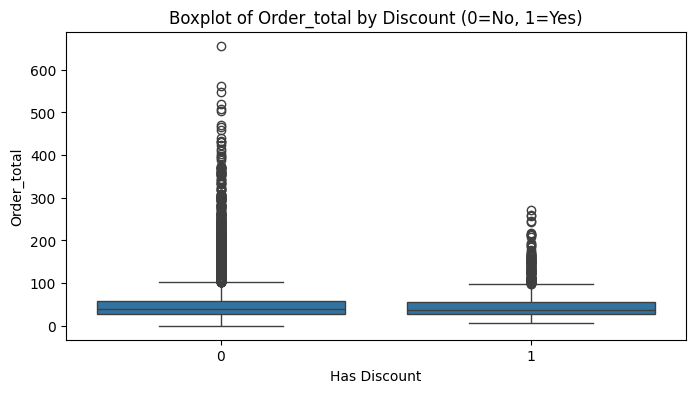

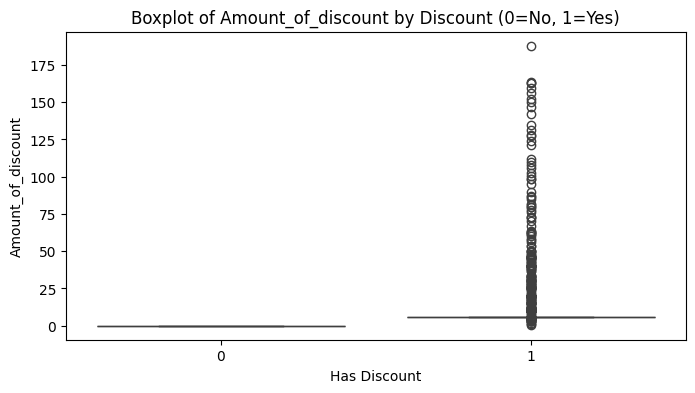

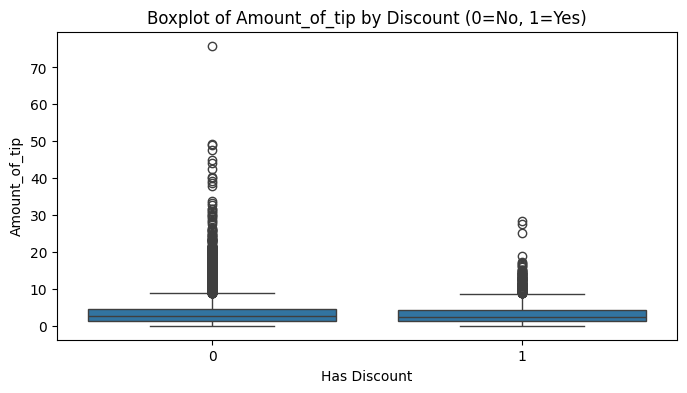

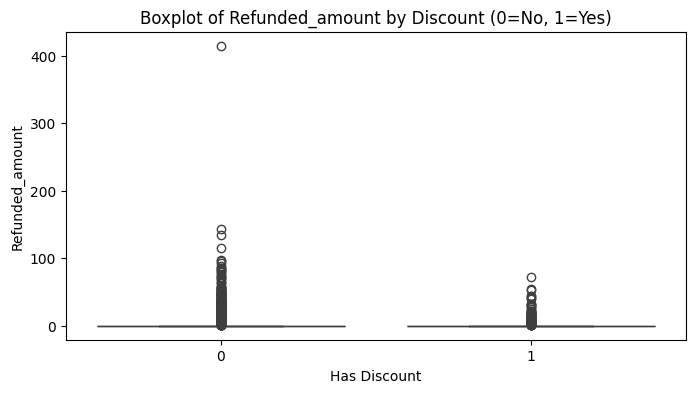

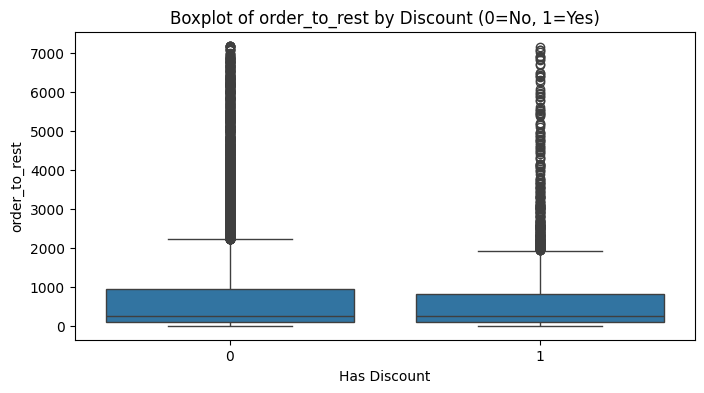

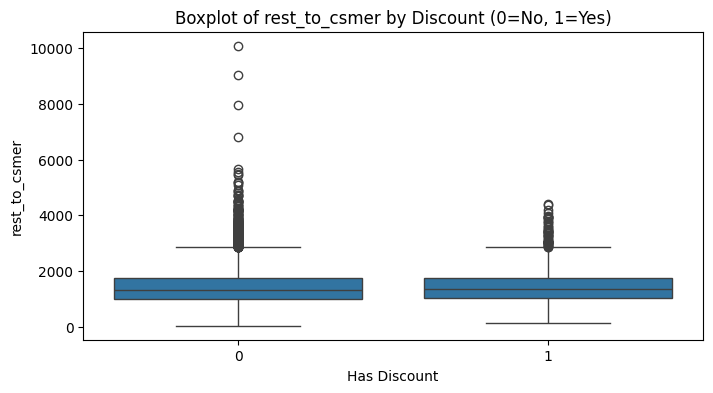

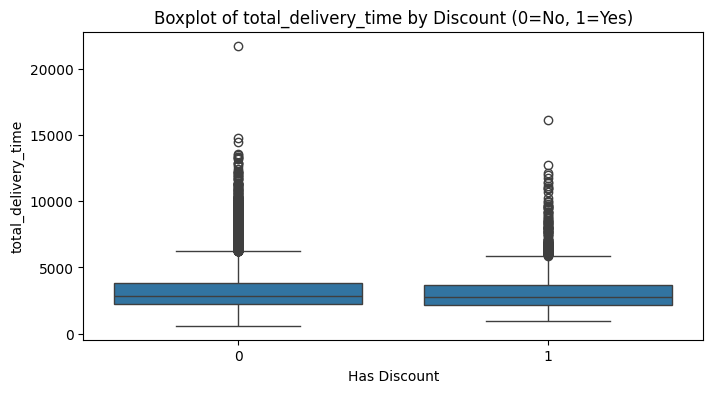

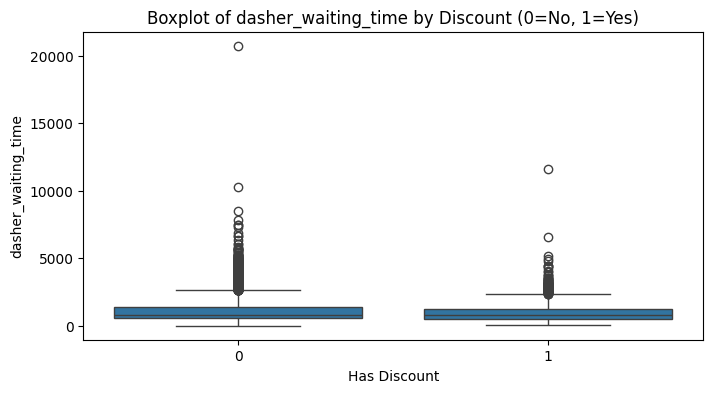

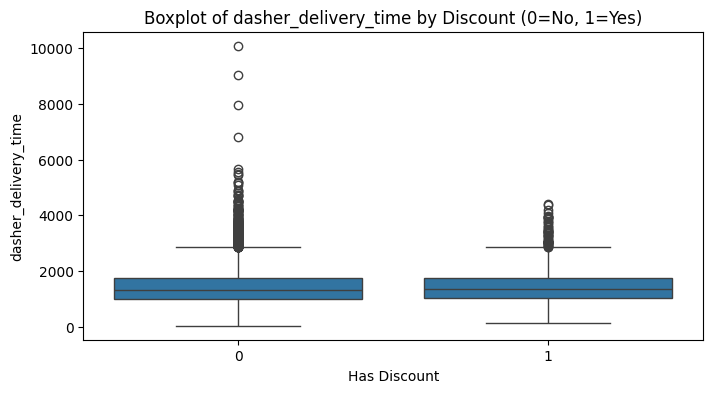

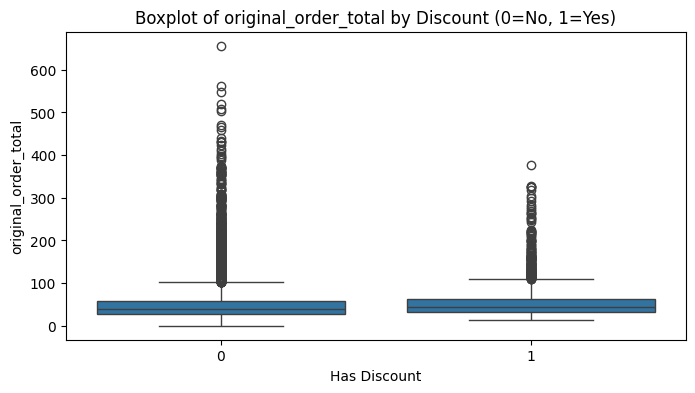

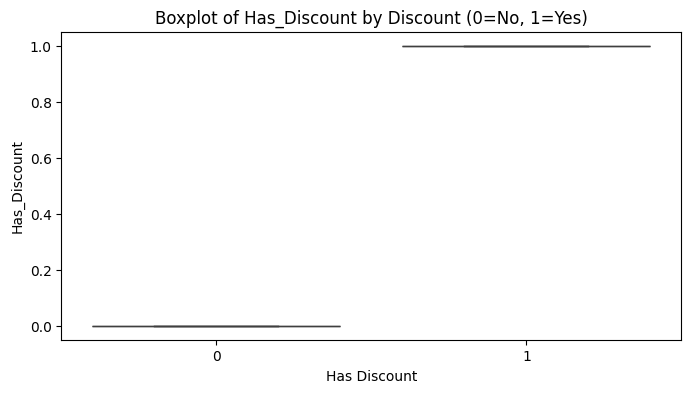

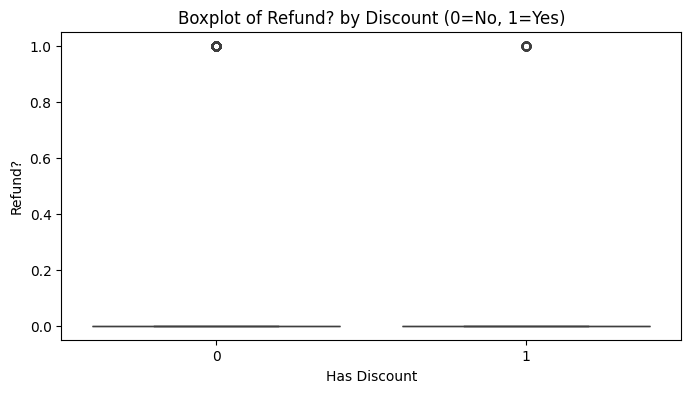

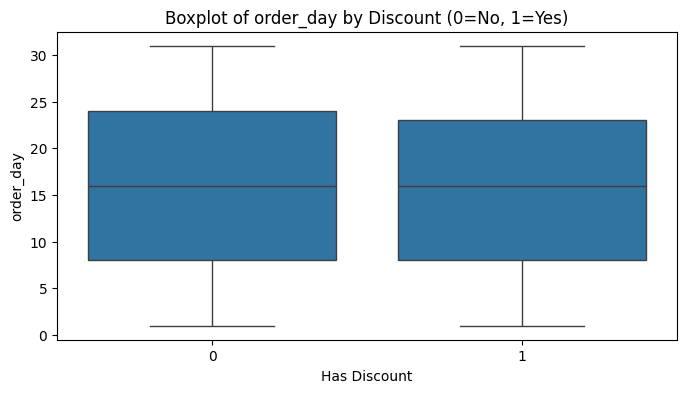

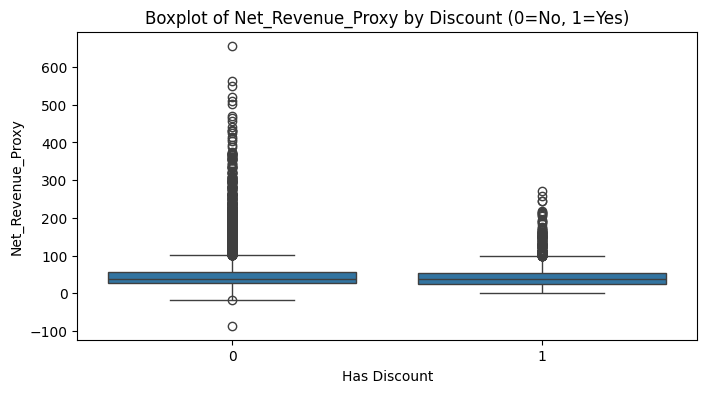

In [40]:

# Boxplots for numerical columns
numeric_cols = df_viz.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    if col not in ignore_columns:  
        plt.figure(figsize=(8,4))
        sns.boxplot(x="Has_Discount", y=col, data=df_viz)
        plt.title(f"Boxplot of {col} by Discount (0=No, 1=Yes)")
        plt.xlabel("Has Discount")
        plt.ylabel(col)
        plt.show()

## Outlier Check

In [41]:


def summarize_by_discount(df, numeric_cols, discount_col="Amount_of_discount"):
    results = []

    for col in numeric_cols:
        if col not in ignore_columns:
            for has_disc, group in df.groupby(df[discount_col] > 0):
                # statistics
                mean_val = group[col].mean()
                median_val = group[col].median()
                q1 = group[col].quantile(0.25)
                q3 = group[col].quantile(0.75)
                iqr = q3 - q1

                # outlier check（1.5 * IQR）
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                outlier_ratio = ((group[col] < lower_bound) | (group[col] > upper_bound)).mean()* 100

                results.append({
                    "Column": col,
                    "Has_Discount": int(has_disc),
                    "Mean": mean_val,
                    "Median": median_val,
                    "IQR": iqr,
                    "Outlier_Ratio": f"{outlier_ratio:.2f}%"
                })

    return pd.DataFrame(results)


summary_table = summarize_by_discount(df_viz, numeric_cols)
summary_table


,Column,Has_Discount,Mean,Median,IQR,Outlier_Ratio
0,Order_total,0,49.532375,38.46,30.2900,6.53%
1,Order_total,1,45.745525,38.03,28.9175,5.40%
2,Amount_of_discount,0,0.000000,0.00,0.0000,0.00%
3,Amount_of_discount,1,8.841114,6.00,0.0000,10.88%
4,Amount_of_tip,0,3.426052,2.53,2.9900,5.39%
5,Amount_of_tip,1,3.163448,2.45,2.9600,4.65%
6,Refunded_amount,0,0.598171,0.00,0.0000,2.66%
7,Refunded_amount,1,0.411832,0.00,0.0000,2.53%
8,order_to_rest,0,732.272894,250.00,854.5000,8.65%
9,order_to_rest,1,687.789275,243.50,738.0000,9.71%


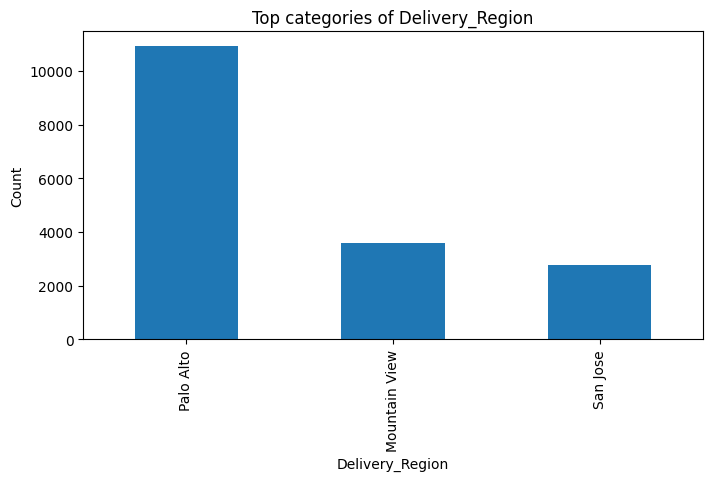

In [42]:

# 2. Categorical Values
cat_cols = df_viz.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    df_viz[col].value_counts().head(20).plot(kind='bar')  
    plt.title(f"Top categories of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# df.to_excel('dd_sample.xlsx', index=False)

## Correlation

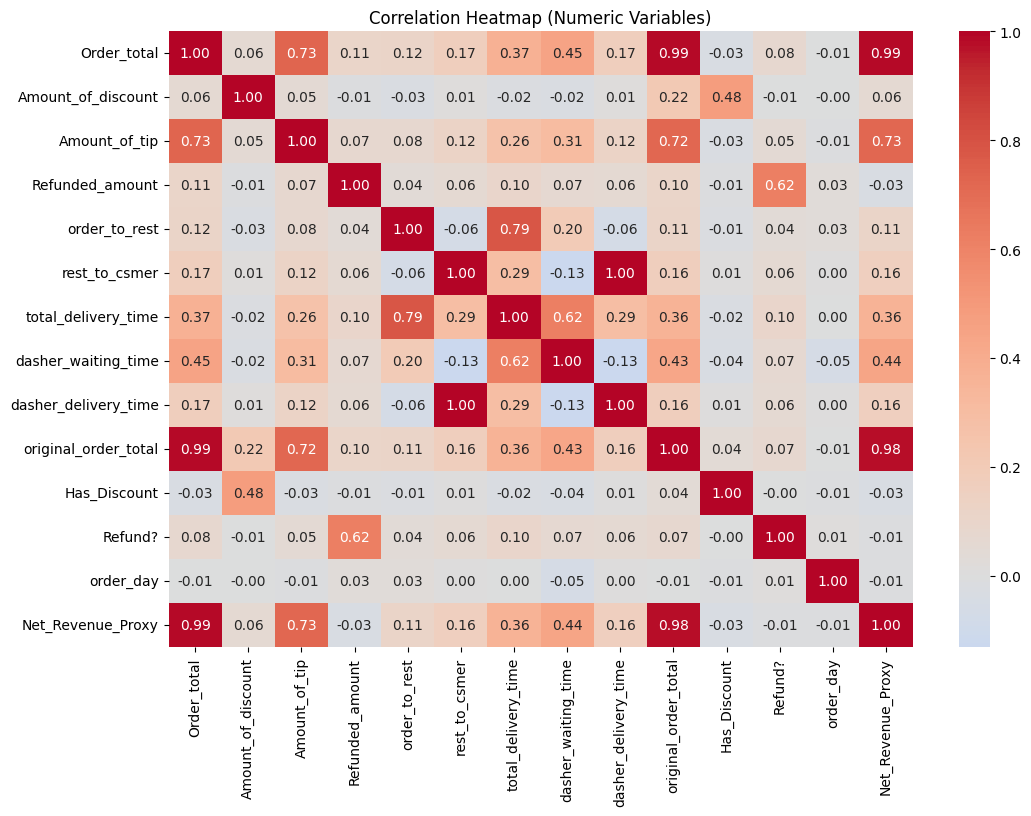

In [43]:
numeric_cols = [c for c in df_viz.select_dtypes(include=['int64', 'float64']).columns 
                if c not in ignore_columns]

plt.figure(figsize=(12,8))
corr = df_viz[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()

## Significance Test

In [44]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

stat_results = []

discount_group = df[df['Amount_of_discount'] > 0]
no_discount_group = df[df['Amount_of_discount'] == 0]

# ---------- 1. numerical ----------
numeric_metrics = {
    "Order_total": "Customer-paid AOV",
    "original_order_total": "Gross AOV",
    "total_delivery_time": "Total Delivery Time",
    "dasher_waiting_time": "Dasher Waiting Time",
    "dasher_delivery_time": "Dasher Delivery Time",
    "Amount_of_tip": "Tip Amount"
}

for col, metric_name in numeric_metrics.items():
    x = discount_group[col].dropna()
    y = no_discount_group[col].dropna()

    # t-test
    t_stat, t_p = ttest_ind(x, y, equal_var=False)

    # non-parametric 
    u_stat, u_p = mannwhitneyu(x, y, alternative="two-sided")

    stat_results.append({
        "Metric": metric_name,
        "Test": "t-test",
        "p_value": t_p,
        "Significant?": "Yes" if t_p < 0.05 else "No"
    })

    stat_results.append({
        "Metric": metric_name,
        "Test": "Mann-Whitney U",
        "p_value": u_p,
        "Significant?": "Yes" if u_p < 0.05 else "No"
    })


# ---------- 2. Ratios（Chi-square） ----------
# Refund Rate
contingency_refund = pd.crosstab(df['Amount_of_discount'] > 0, df['Refunded_amount'] > 0)
chi2, p_refund, _, _ = chi2_contingency(contingency_refund)
stat_results.append({
    "Metric": "Refund Rate",
    "Test": "Chi-square",
    "p_value": p_refund,
    "Significant?": "Yes" if p_refund < 0.05 else "No"
})

# New Customer Rate
contingency_new = pd.crosstab(df['Amount_of_discount'] > 0, df['Is_New'] == 1)
chi2, p_new, _, _ = chi2_contingency(contingency_new)
stat_results.append({
    "Metric": "New Customer Rate",
    "Test": "Chi-square",
    "p_value": p_new,
    "Significant?": "Yes" if p_new < 0.05 else "No"
})


# ---------- 3. Per-order（t-test） ----------

df['Net_Revenue_Proxy'] = df['original_order_total'] - df['Amount_of_discount'] - df['Refunded_amount']

discount_group    = df[df['Amount_of_discount'] > 0]
no_discount_group = df[df['Amount_of_discount'] == 0]

# t-test
x = discount_group['Net_Revenue_Proxy'].dropna()
y = no_discount_group['Net_Revenue_Proxy'].dropna()

t_stat, t_p = ttest_ind(x, y, equal_var=False)

stat_results.append({
    "Metric": "Net Revenue Proxy per Order",
    "Test": "t-test",
    "p_value": t_p,
    "Significant?": "Yes" if t_p < 0.05 else "No"
})


results_df = pd.DataFrame(stat_results)
print(results_df)


                         Metric            Test       p_value Significant?
0             Customer-paid AOV          t-test  2.374336e-08          Yes
1             Customer-paid AOV  Mann-Whitney U  3.707388e-02          Yes
2                     Gross AOV          t-test  2.502287e-10          Yes
3                     Gross AOV  Mann-Whitney U  1.108261e-44          Yes
4           Total Delivery Time          t-test  2.123878e-03          Yes
5           Total Delivery Time  Mann-Whitney U  1.130832e-02          Yes
6           Dasher Waiting Time          t-test  1.883772e-06          Yes
7           Dasher Waiting Time  Mann-Whitney U  7.057865e-03          Yes
8          Dasher Delivery Time          t-test  4.856422e-01           No
9          Dasher Delivery Time  Mann-Whitney U  2.661761e-01           No
10                   Tip Amount          t-test  1.549851e-05          Yes
11                   Tip Amount  Mann-Whitney U  3.882294e-03          Yes
12                  Refun

## Direction + Impact

In [45]:
from scipy.stats import ttest_ind

def effect_size_label(d):
    if abs(d) < 0.2:
        return "Negligible"
    elif abs(d) < 0.5:
        return "Small"
    elif abs(d) < 0.8:
        return "Medium"
    else:
        return "Large"

metrics = [
    ("Order_total", "Customer-paid AOV"),
    ("original_order_total", "Gross AOV"),
    ("total_delivery_time", "Total Delivery Time (sec)"),
    ("dasher_waiting_time", "Dasher Waiting Time (sec)"),
    ("dasher_delivery_time", "Dasher Delivery Time (sec)"),
    ("Amount_of_tip", "Tip Amount ($)"),
    ("Net_Revenue_Proxy", "Net Revenue Proxy per Order ($)"),
]
g1 = df[df['Amount_of_discount'] > 0]
g0 = df[df['Amount_of_discount'] == 0]

def cohens_d_welch(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2: return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)

    s = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    if s == 0 or np.isnan(s): return np.nan
    return (x.mean() - y.mean()) / s

rows = []
for col, name in metrics:
    x = g1[col].dropna()
    y = g0[col].dropna()

    # t-test
    t_stat, p_val = ttest_ind(x, y, equal_var=False)

    # Cohen's d
    d = cohens_d_welch(x, y)

    rows.append({
        "Metric": name,
        "Mean_YesDisc": x.mean(),
        "Mean_NoDisc": y.mean(),
        "Mean_Diff(Yes-No)": x.mean() - y.mean(),
        "p<0.05?": "Yes" if p_val < 0.05 else "No",
        "Higher Group": "YesDisc" if x.mean() > y.mean() else "NoDisc",
        "Cohen's d": round(d, 3),
        "Effect Size": effect_size_label(d)
    })

prop_results = []

# Refund Rate
refund_rate_yes = (discount_group['Refunded_amount'] > 0).mean()
refund_rate_no  = (no_discount_group['Refunded_amount'] > 0).mean()
prop_results.append({
    "Metric": "Refund Rate",
    "Mean_YesDisc": refund_rate_yes,
    "Mean_NoDisc": refund_rate_no,
    "Mean_Diff(Yes-No)": refund_rate_yes - refund_rate_no,
    "p<0.05?": "Yes" if p_refund < 0.05 else "No",
    "Higher Group": "YesDisc" if refund_rate_yes > refund_rate_no else "NoDisc",
    "Cohen's d": "N/A",
    "Effect Size": "Proportion"
})

# New Customer Rate
new_rate_yes = (discount_group['Is_New'] == 1).mean()
new_rate_no  = (no_discount_group['Is_New'] == 1).mean()
prop_results.append({
    "Metric": "New Customer Rate",
    "Mean_YesDisc": new_rate_yes,
    "Mean_NoDisc": new_rate_no,
    "Mean_Diff(Yes-No)": new_rate_yes - new_rate_no,
    "p<0.05?": "Yes" if p_new < 0.05 else "No",
    "Higher Group": "YesDisc" if new_rate_yes > new_rate_no else "NoDisc",
    "Cohen's d": "N/A",
    "Effect Size": "Proportion"
})

summary_table = pd.DataFrame(rows)

final_results = pd.concat([summary_table, pd.DataFrame(prop_results)], ignore_index=True)

final_results 


,Metric,Mean_YesDisc,Mean_NoDisc,Mean_Diff(Yes-No),p<0.05?,Higher Group,Cohen's d,Effect Size
0,Customer-paid AOV,45.745525,49.532375,-3.786850,Yes,NoDisc,-0.095,Negligible
1,Gross AOV,54.586639,49.532375,5.054264,Yes,YesDisc,0.124,Negligible
2,Total Delivery Time (sec),3158.936556,3256.854838,-97.918282,Yes,NoDisc,-0.063,Negligible
3,Dasher Waiting Time (sec),999.557741,1086.680839,-87.123099,Yes,NoDisc,-0.104,Negligible
4,Dasher Delivery Time (sec),1453.827030,1443.434451,10.392579,No,YesDisc,0.016,Negligible
5,Tip Amount ($),3.163448,3.426052,-0.262604,Yes,NoDisc,-0.08,Negligible
6,Net Revenue Proxy per Order ($),45.333693,48.934204,-3.600510,Yes,NoDisc,-0.09,Negligible
7,Refund Rate,0.025302,0.026554,-0.001252,No,NoDisc,N/A,Proportion
8,New Customer Rate,0.243202,0.184721,0.058481,Yes,YesDisc,N/A,Proportion


# correlation between tip rate & campaign

In [46]:
from scipy.stats import ttest_ind, mannwhitneyu

# 1. define tip rate
df["tip_rate_original"] = df["Amount_of_tip"] / df["original_order_total"]
df["tip_rate_paid"] = df["Amount_of_tip"] / df["Order_total"]

# 2. discount vs no discount
discount_group = df[df["Has_Discount"] == 1]
no_discount_group = df[df["Has_Discount"] == 0]

results_tiprate = []

# ---------- tip_rate vs origional price ----------
x = discount_group["tip_rate_original"].dropna()
y = no_discount_group["tip_rate_original"].dropna()

t_stat, t_p = ttest_ind(x, y, equal_var=False)
mw_stat, mw_p = mannwhitneyu(x, y, alternative="two-sided")

results_tiprate.append({
    "Metric": "Tip Rate vs Original Price",
    "t-test p_value": t_p,
    "Mann-Whitney p_value": mw_p,
    "Significant?": "Yes" if t_p < 0.05 or mw_p < 0.05 else "No"
})

# ---------- tip_rate vs paid amount ----------
x = discount_group["tip_rate_paid"].dropna()
y = no_discount_group["tip_rate_paid"].dropna()

t_stat, t_p = ttest_ind(x, y, equal_var=False)
mw_stat, mw_p = mannwhitneyu(x, y, alternative="two-sided")

results_tiprate.append({
    "Metric": "Tip Rate vs Paid Amount",
    "t-test p_value": t_p,
    "Mann-Whitney p_value": mw_p,
    "Significant?": "Yes" if t_p < 0.05 or mw_p < 0.05 else "No"
})

import pandas as pd
results_df = pd.DataFrame(results_tiprate)
print(results_df)


                       Metric  t-test p_value  Mann-Whitney p_value  \
0  Tip Rate vs Original Price    2.851397e-55          1.078181e-65   
1     Tip Rate vs Paid Amount    4.520850e-01          2.483377e-01   

  Significant?  
0          Yes  
1           No  


In [47]:
daily = df.groupby("order_day").agg(
    total_orders=("Customer_placed_order_datetime", "count"),
    total_dashers=("Driver_ID", "nunique"),
    discount_orders=("Has_Discount", "sum")
).reset_index()

daily["adoption_rate"] = daily["discount_orders"] / daily["total_orders"]
daily["orders_per_dasher"] = daily["total_orders"] / daily["total_dashers"]

# correlation analysis
from scipy.stats import pearsonr, spearmanr
corr, pval = pearsonr(daily["adoption_rate"], daily["orders_per_dasher"])
print("Pearson correlation:", corr, "p:", pval)

spearman_corr, spearman_p = spearmanr(daily["adoption_rate"], daily["orders_per_dasher"])
print("Spearman correlation:", spearman_corr, "p:", spearman_p)


Pearson correlation: 0.1303549327111997 p: 0.4845825304917199
Spearman correlation: 0.42661290322580653 p: 0.01669687826038512


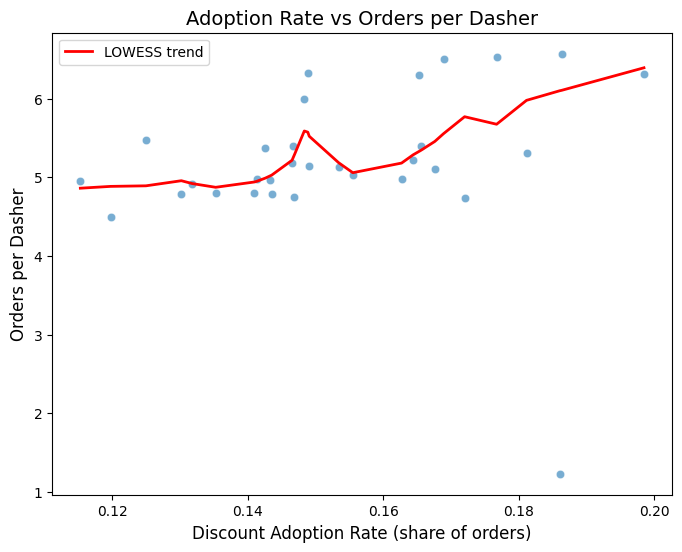

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


plt.figure(figsize=(8,6))

# Scatter plot
sns.scatterplot(
    data=daily,
    x="adoption_rate",
    y="orders_per_dasher",
    alpha=0.6
)

# LOWESS smoothing
lowess = sm.nonparametric.lowess
z = lowess(daily["orders_per_dasher"], daily["adoption_rate"], frac=0.3)
plt.plot(z[:,0], z[:,1], color="red", linewidth=2, label="LOWESS trend")

plt.title("Adoption Rate vs Orders per Dasher", fontsize=14)
plt.xlabel("Discount Adoption Rate (share of orders)", fontsize=12)
plt.ylabel("Orders per Dasher", fontsize=12)
plt.legend()
plt.show()


# refund & delivery time

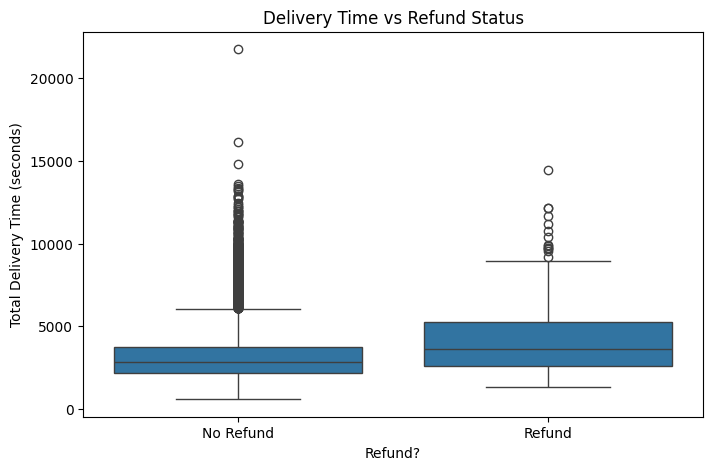

T-test p-value: 5.899646168653051e-21
Mann-Whitney U p-value: 4.1907883387433606e-29
avg delivery time（No Refund）: 3216.668325630999
avg delivery time（Refund）: 4173.6608315098465


In [49]:

plt.figure(figsize=(8,5))
sns.boxplot(x="Refund?", y="total_delivery_time", data=df)
plt.xticks([0,1], ["No Refund", "Refund"])
plt.title("Delivery Time vs Refund Status")
plt.ylabel("Total Delivery Time (seconds)")
plt.show()


refund_group = df[df["Refund?"]==1]["total_delivery_time"].dropna()
no_refund_group = df[df["Refund?"]==0]["total_delivery_time"].dropna()

t_stat, t_p = ttest_ind(refund_group, no_refund_group, equal_var=False)
u_stat, u_p = mannwhitneyu(refund_group, no_refund_group, alternative="two-sided")

print("T-test p-value:", t_p)
print("Mann-Whitney U p-value:", u_p)
print("avg delivery time（No Refund）:", no_refund_group.mean())
print("avg delivery time（Refund）:", refund_group.mean())

# Effectiveness by regions

In [50]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency


region_results = []

for region, region_df in df.groupby("Delivery_Region"):  
    disc   = region_df[region_df['Amount_of_discount'] > 0]
    nodisc = region_df[region_df['Amount_of_discount'] == 0]
    
    # -------- numerical --------
    numeric_metrics = {
        "Order_total": "Customer-paid AOV",
        "original_order_total": "Gross AOV",
        "total_delivery_time": "Total Delivery Time (sec)",
        "dasher_waiting_time": "Dasher Waiting Time (sec)",
        "dasher_delivery_time": "Dasher Delivery Time (sec)",
        "Amount_of_tip": "Tip Amount ($)",
        "Net_Revenue_Proxy": "Net Revenue Proxy per Order ($)"
    }
    
    def cohen_d(a, b):
        nx, ny = len(a), len(b)
        s = np.sqrt(((nx-1)*a.var(ddof=1) + (ny-1)*b.var(ddof=1)) / (nx+ny-2))
        return (a.mean() - b.mean()) / s if s > 0 else np.nan

    for col, metric_name in numeric_metrics.items():
        x, y = disc[col].dropna(), nodisc[col].dropna()
        if len(x) == 0 or len(y) == 0: 
            continue
        
        mean_disc, mean_nodisc = x.mean(), y.mean()
        diff = mean_disc - mean_nodisc
        
        # Welch's t-test
        t_stat, t_p = ttest_ind(x, y, equal_var=False)
        d_val = cohen_d(x, y)
        
        region_results.append({
            "Delivery_Region": region,
            "Metric": metric_name,
            "Mean_YesDisc": mean_disc,
            "Mean_NoDisc": mean_nodisc,
            "Mean_Diff(Yes-No)": diff,
            "p<0.05?": "Yes" if t_p < 0.05 else "No",
            "Higher Group": "YesDisc" if mean_disc > mean_nodisc else "NoDisc",
            "Cohen's d": round(d_val, 3) if pd.notna(d_val) else "N/A",
            "Effect Size": (
                "Negligible" if abs(d_val) < 0.2 
                else "Small" if abs(d_val)<0.5 
                else "Medium" if abs(d_val)<0.8 
                else "Large"
            )
        })
    
    # -------- ratios --------
    # Refund Rate
    contingency_refund = pd.crosstab(region_df['Amount_of_discount'] > 0, region_df['Refunded_amount'] > 0)
    if contingency_refund.shape == (2, 2):  
        chi2, p_refund, _, _ = chi2_contingency(contingency_refund)
        refund_rate_yes = (disc['Refunded_amount'] > 0).mean()
        refund_rate_no  = (nodisc['Refunded_amount'] > 0).mean()
        region_results.append({
            "Delivery_Region": region,
            "Metric": "Refund Rate",
            "Mean_YesDisc": refund_rate_yes,
            "Mean_NoDisc": refund_rate_no,
            "Mean_Diff(Yes-No)": refund_rate_yes - refund_rate_no,
            "p<0.05?": "Yes" if p_refund < 0.05 else "No",
            "Higher Group": "YesDisc" if refund_rate_yes > refund_rate_no else "NoDisc",
            "Cohen's d": "N/A",
            "Effect Size": "Proportion"
        })
    
    # New Customer Rate
    contingency_new = pd.crosstab(region_df['Amount_of_discount'] > 0, region_df['Is_New'] == 1)
    if contingency_new.shape == (2, 2):
        chi2, p_new, _, _ = chi2_contingency(contingency_new)
        new_rate_yes = (disc['Is_New'] == 1).mean()
        new_rate_no  = (nodisc['Is_New'] == 1).mean()
        region_results.append({
            "Delivery_Region": region,
            "Metric": "New Customer Rate",
            "Mean_YesDisc": new_rate_yes,
            "Mean_NoDisc": new_rate_no,
            "Mean_Diff(Yes-No)": new_rate_yes - new_rate_no,
            "p<0.05?": "Yes" if p_new < 0.05 else "No",
            "Higher Group": "YesDisc" if new_rate_yes > new_rate_no else "NoDisc",
            "Cohen's d": "N/A",
            "Effect Size": "Proportion"
        })


region_results_df = pd.DataFrame(region_results)
region_results_df

,Delivery_Region,Metric,Mean_YesDisc,Mean_NoDisc,Mean_Diff(Yes-No),p<0.05?,Higher Group,Cohen's d,Effect Size
0,Mountain View,Customer-paid AOV,46.450934,50.198578,-3.747645,Yes,NoDisc,-0.094,Negligible
1,Mountain View,Gross AOV,54.199730,50.198578,4.001152,Yes,YesDisc,0.099,Negligible
2,Mountain View,Total Delivery Time (sec),3172.387967,3200.484026,-28.096059,No,NoDisc,-0.019,Negligible
3,Mountain View,Dasher Waiting Time (sec),1040.783854,1046.903880,-6.120026,No,NoDisc,-0.008,Negligible
4,Mountain View,Dasher Delivery Time (sec),1414.380208,1377.100970,37.279238,No,YesDisc,0.057,Negligible
5,Mountain View,Tip Amount ($),3.323527,3.498435,-0.174908,No,NoDisc,-0.053,Negligible
6,Mountain View,Net Revenue Proxy per Order ($),45.885975,49.634837,-3.748862,Yes,NoDisc,-0.094,Negligible
7,Mountain View,Refund Rate,0.029046,0.028435,0.000611,No,YesDisc,N/A,Proportion
8,Mountain View,New Customer Rate,0.203320,0.188818,0.014502,No,YesDisc,N/A,Proportion
9,Palo Alto,Customer-paid AOV,46.904646,50.445438,-3.540792,Yes,NoDisc,-0.083,Negligible
